In [ ]:
# Update sklearn to prevent version mismatches
# !pip install sklearn --upgrade

## Dependencies

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymongo
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from config import mongo_conn

## Load Perfume Data

In [2]:
# Initialize PyMongo to work with MongoDBs
client = pymongo.MongoClient(mongo_conn)
db = client.perfumes_db
perfume_df = pd.DataFrame(list(db.perfume_data.find()))
perfume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           478 non-null    object
 1   name          478 non-null    object
 2   company       478 non-null    object
 3   image         478 non-null    object
 4   for_gender    478 non-null    object
 5   rating        478 non-null    object
 6   number_votes  478 non-null    object
 7   main accords  478 non-null    object
 8   description   478 non-null    object
 9   top notes     478 non-null    object
 10  middle notes  478 non-null    object
 11  base notes    478 non-null    object
 12  longevity     478 non-null    object
 13  sillage       478 non-null    object
 14  gender_vote   478 non-null    object
 15  price value   478 non-null    object
dtypes: object(16)
memory usage: 59.9+ KB


## Preprocess Data

### MultiLabelBinarizer

In [3]:
# convert Notes list to multiple features columns
mlb = MultiLabelBinarizer()

# Top Notes
X_top_notes = mlb.fit_transform(perfume_df["top notes"])
column_names = ["top_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_top_notes, columns=column_names))

# Middle Notes
X_middle_notes = mlb.fit_transform(perfume_df["middle notes"])
column_names = ["middle_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_middle_notes, columns=column_names))

# Base notes
X_base_notes = mlb.fit_transform(perfume_df["base notes"])
column_names = ["base_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_base_notes, columns=column_names))

perfume_df.columns

Index(['_id', 'name', 'company', 'image', 'for_gender', 'rating',
       'number_votes', 'main accords', 'description', 'top notes',
       ...
       'base_note_White Sandalwood', 'base_note_White Woods',
       'base_note_Woodsy Notes', 'base_note_Woody Notes', 'base_note_iris',
       'base_note_oak moss', 'base_note_resins', 'base_note_vanilla bean',
       'base_note_vetyver', 'base_note_white honey'],
      dtype='object', length=782)

In [4]:
# replace empty values with 0
perfume_df = perfume_df.fillna(0)
perfume_df.head()

,_id,name,company,image,for_gender,rating,number_votes,main accords,description,top notes,...,base_note_White Sandalwood,base_note_White Woods,base_note_Woodsy Notes,base_note_Woody Notes,base_note_iris,base_note_oak moss,base_note_resins,base_note_vanilla bean,base_note_vetyver,base_note_white honey
0,603e24ef888aaf1a0d7c0db8,Angels' Share,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,4.31,682,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",Angels' Share by By Kilian is a Oriental Vanil...,[Cognac],...,0,0,0,0,0,0,0,0,0,0
1,603e24ef888aaf1a0d7c0db9,My Way,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,3.57,1471,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...",My Way by Giorgio Armani is a Floral fragrance...,"[Orange Blossom, Bergamot]",...,0,0,0,0,0,0,0,0,0,0
2,603e24ef888aaf1a0d7c0dba,Libre Intense,Yves Saint Laurent,https://fimgs.net/mdimg/perfume/375x500.62318.jpg,for women,4.02,858,"{'vanilla': 100.0, 'aromatic': 71.4216, 'sweet...",Libre Intense by Yves Saint Laurent is a Orien...,"[Lavender, Mandarin Orange, Bergamot]",...,0,0,0,0,0,0,0,0,0,0
3,603e24ef888aaf1a0d7c0dbb,Dior Homme 2020,Christian Dior,https://fimgs.net/mdimg/perfume/375x500.58714.jpg,for men,3.42,1402,"{'woody': 100.0, 'musky': 72.7229, 'amber': 53...",Dior Homme 2020 by Christian Dior is a Woody f...,"[Bergamot, Pink Pepper, elemi]",...,0,0,0,0,0,0,0,0,0,0
4,603e24ef888aaf1a0d7c0dbc,Acqua di Giò Profondo,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.59532.jpg,for men,4.03,869,"{'aromatic': 100.0, 'marine': 93.2493, 'citrus...",Acqua di Giò Profondo by Giorgio Armani is a A...,"[Sea Notes, Aquozone, Bergamot, Green Mandarin]",...,0,0,0,0,0,0,0,0,0,0


### X (data) and y (target)

In [5]:
# drop unnecessary columns
X_data = perfume_df.drop(["_id", "name", "company", "image", "for_gender", "rating", "number_votes", "main accords", "description", "top notes", "middle notes", "base notes", "longevity", "sillage", "gender_vote", "price value"], axis=1)

y = perfume_df["for_gender"]

target_names = ["Men", "Women", "Unisex"]

### Create notes_features collection

In [6]:
# find all the notes from perfumes collections
perfumes_features_list = X_data.columns
notes_list = []
for note in perfumes_features_list:
    x = note.rsplit("_", 1)
    notes_list.append(x[1])
notes_list

['African Orange flower',
 'Agarwood (Oud)',
 'Aldehydes',
 'Almond',
 'Almond Blossom',
 'Amalfi Lemon',
 'Amber',
 'Ambrette (Musk Mallow)',
 'Angelica',
 'Anise',
 'Apple',
 'Apricot',
 'Aquozone',
 'Artemisia',
 'Asafoetida',
 'Bamboo',
 'Basil',
 'Bay Leaf',
 'Bellflower',
 'Bergamot',
 'Big Strawberry',
 'Bitter Almond',
 'Bitter Orange',
 'Black Cardamom',
 'Black Currant',
 'Black Pepper',
 'Black Tea',
 'Blackberry',
 'Blood Mandarin',
 'Blood Orange',
 'Brazilian Rosewood',
 'Bulgarian Rose',
 'Cactus',
 'Calabrian bergamot',
 'Candy Apple',
 'Caramel',
 'Caraway',
 'Cardamom',
 'Cardamon',
 'Carrot',
 'Carrot Seeds',
 'Cassia',
 'Cassis',
 'Chamomile',
 'Champagne',
 'Cherry',
 'Chili Pepper',
 'Chinotto',
 'Cinnamon',
 'Citruses',
 'Clary Sage',
 'Clementine',
 'Clove',
 'Clover',
 'Cloves',
 'Coconut',
 'Coffee',
 'Cognac',
 'Coriander',
 'Cucumber',
 'Cumin',
 'Cyclamen',
 'Cypress',
 'Dewberry',
 'Elemi resin',
 'Fig',
 'Fig Leaf',
 'Floral Notes',
 'Flowers',
 'Forget m

In [7]:
# find unique notes
unique_notes = set(notes_list)
notes_list_df = pd.DataFrame(list(unique_notes), columns=["Note Name"])
notes_list_df

,Note Name
0,Pink Pepper
1,Camphor
2,Roasted Coffee Beans
3,Orangewood
4,Pine
...,...
486,Hazelnut cocoa spread
487,Egyptian Jasmine
488,Cashmere Musk
489,Cactus


In [8]:
# create a collection for notes features from the perfumes in the collection
notes_features = db.notes_features
# drop collection if it exists
notes_features.drop()
# Creating a collection
notes_features = db.notes_features

In [9]:
# add notes features to mondo db
for jdict in notes_list_df.to_dict(orient='records'):
    notes_features.insert_one(jdict)

In [10]:
# create features with all the notes
note_columns = []
for note in unique_notes:
    note_columns.append("top_note_" + note)
    note_columns.append("middle_note_" + note)
    note_columns.append("base_note_" + note)

In [11]:
#create a dataframe with all features
notes_df = pd.DataFrame(columns=note_columns)
notes_df.loc[len(notes_df)] = 0
notes_df.head()

,top_note_Pink Pepper,middle_note_Pink Pepper,base_note_Pink Pepper,top_note_Camphor,middle_note_Camphor,base_note_Camphor,top_note_Roasted Coffee Beans,middle_note_Roasted Coffee Beans,base_note_Roasted Coffee Beans,top_note_Orangewood,...,base_note_Egyptian Jasmine,top_note_Cashmere Musk,middle_note_Cashmere Musk,base_note_Cashmere Musk,top_note_Cactus,middle_note_Cactus,base_note_Cactus,top_note_Sicilian Orange,middle_note_Sicilian Orange,base_note_Sicilian Orange
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# merge notes data frame with X to get all features
X = pd.merge(X_data, notes_df, how="left")
X = X.fillna(0)
feature_count = X.shape[1]
X.head()

,top_note_African Orange flower,top_note_Agarwood (Oud),top_note_Aldehydes,top_note_Almond,top_note_Almond Blossom,top_note_Amalfi Lemon,top_note_Amber,top_note_Ambrette (Musk Mallow),top_note_Angelica,top_note_Anise,...,top_note_Hazelnut cocoa spread,base_note_Hazelnut cocoa spread,top_note_Egyptian Jasmine,base_note_Egyptian Jasmine,top_note_Cashmere Musk,middle_note_Cashmere Musk,middle_note_Cactus,base_note_Cactus,middle_note_Sicilian Orange,base_note_Sicilian Orange
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create perfume_features collection

In [13]:
# features dataframe
features_df = pd.DataFrame(columns=X.columns)
features_df.loc[len(features_df)] = 0
features_df.head()

,top_note_African Orange flower,top_note_Agarwood (Oud),top_note_Aldehydes,top_note_Almond,top_note_Almond Blossom,top_note_Amalfi Lemon,top_note_Amber,top_note_Ambrette (Musk Mallow),top_note_Angelica,top_note_Anise,...,top_note_Hazelnut cocoa spread,base_note_Hazelnut cocoa spread,top_note_Egyptian Jasmine,base_note_Egyptian Jasmine,top_note_Cashmere Musk,middle_note_Cashmere Musk,middle_note_Cactus,base_note_Cactus,middle_note_Sicilian Orange,base_note_Sicilian Orange
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# create a collection name for perfume features
perfume_features = db.perfume_features
# drop collection if it exists
perfume_features.drop()
# Creating a collection
perfume_features = db.perfume_features

In [15]:
# add perfume features to mondo db
for jdict in features_df.to_dict(orient='records'):
    perfume_features.insert_one(jdict)

## Finding Feature Importance

In [ ]:
X.hist(figsize=(15,20))

In [ ]:
# heatmap to figure best features. Features that are more green are highly correlated and thus not a good option
plt.figure(figsize=(15,10))
mask = np.triu(np.ones_like(X.corr(), dtype=np.bool))
heatmap = sns.heatmap(X.corr(), mask=mask, vmin=-1, vmax=1, cmap="BrBG")

In [16]:
# Finding the most important features using RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X, y)

importance_df = pd.DataFrame({"feature": X.columns, 
                              "Importance": round(rf.feature_importances_[0],20)})
importance_df.sort_values("Importance", ascending=False)

,feature,Importance
0,top_note_African Orange flower,0.000718
979,base_note_Cupcake,0.000718
988,top_note_Vanille,0.000718
987,base_note_Lotus,0.000718
986,base_note_Blood Mandarin,0.000718
...,...,...
489,middle_note_Praline,0.000718
488,middle_note_Powdery Notes,0.000718
487,middle_note_Poppy,0.000718
486,middle_note_Popocorn,0.000718


## Train and Test data

In [17]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
# Create a MinMaxScaler model and fit it to the training data
# X_scaler = MinMaxScaler().fit(X_train)

In [19]:
# Transform the training and testing data using the X_scaler and y_scaler models
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

## SVC (Linear and RBF)

In [20]:
model = SVC()

# Fit model using GridSearchCV
param_grid = {'C': [5, 20, 50],
              'kernel': ('linear', 'rbf')}
grid = GridSearchCV(model, param_grid, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=5, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. C=5, kernel=linear, score=0.694, total=   0.2s
[CV] C=5, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................. C=5, kernel=linear, score=0.597, total=   0.2s
[CV] C=5, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] .................. C=5, kernel=linear, score=0.625, total=   0.2s
[CV] C=5, kernel=linear ..............................................
[CV] .................. C=5, kernel=linear, score=0.620, total=   0.2s
[CV] C=5, kernel=linear ..............................................
[CV] .................. C=5, kernel=linear, score=0.606, total=   0.2s
[CV] C=5, kernel=rbf .................................................
[CV] ..................... C=5, kernel=rbf, score=0.681, total=   0.3s
[CV] C=5, kernel=rbf .................................................
[CV] ..................... C=5, kernel=rbf, score=0.611, total=   0.3s
[CV] C=5, kernel=rbf .................................................
[CV] ..................... C=5, kernel=rbf, score=0.667, total=   0.3s
[CV] C=5, kernel=rbf .................................................
[CV] ..................... C=5, kernel=rbf, score=0.648, total=   0.3s
[CV] C=5, kernel=rbf .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    7.1s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [5, 20, 50], 'kernel': ('linear', 'rbf')},
             verbose=3)

In [21]:
# Model evaluation metrics
grid_score = grid.score(X_test, y_test)
print('Test Acc: %.3f' % grid_score)
predictions = grid.predict(X_test)
grid_report = classification_report(y_test, predictions)
print(grid_report)
print(grid.best_params_)


Test Acc: 0.617
                   precision    recall  f1-score   support

          for men       0.61      0.55      0.58        31
        for women       0.63      0.92      0.75        51
for women and men       0.59      0.26      0.36        38

         accuracy                           0.62       120
        macro avg       0.61      0.58      0.56       120
     weighted avg       0.61      0.62      0.58       120

{'C': 20, 'kernel': 'rbf'}


### KNearestNeighbor

k: 1, Train/Test Score: 0.983/0.483
k: 3, Train/Test Score: 0.709/0.425
k: 5, Train/Test Score: 0.637/0.425
k: 7, Train/Test Score: 0.575/0.417
k: 9, Train/Test Score: 0.570/0.425
k: 11, Train/Test Score: 0.561/0.425
k: 13, Train/Test Score: 0.561/0.425
k: 15, Train/Test Score: 0.559/0.425


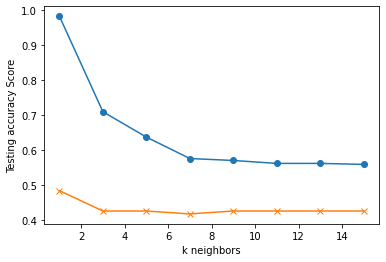

In [22]:
# Instantiate model 2 (KNeighborsClassifier)
train_scores = []
test_scores = []
for k in range(1, 16, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 16, 2), train_scores, marker='o')
plt.plot(range(1, 16, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()


In [23]:
# Model evaluation metrics
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
print('k=2 Test Acc: %.3f' % knn_score)
predictions = knn.predict(X_test)
knn_report = classification_report(y_test, predictions)
print(knn_report)


k=2 Test Acc: 0.433
                   precision    recall  f1-score   support

          for men       0.50      0.06      0.11        31
        for women       0.43      0.96      0.59        51
for women and men       0.50      0.03      0.05        38

         accuracy                           0.43       120
        macro avg       0.48      0.35      0.25       120
     weighted avg       0.47      0.43      0.30       120



### Decision Tree

In [24]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)
predictions = clf.predict(X_test)
print('Test Acc: %.3f' % clf_score)
clf_report = classification_report(y_test, predictions,
                            target_names=target_names)
print(clf_report)

Test Acc: 0.467
              precision    recall  f1-score   support

         Men       0.35      0.29      0.32        31
       Women       0.61      0.75      0.67        51
      Unisex       0.28      0.24      0.26        38

    accuracy                           0.47       120
   macro avg       0.41      0.42      0.42       120
weighted avg       0.44      0.47      0.45       120



### RandomForestTree

In [25]:
rf = RandomForestClassifier(n_estimators=100)
rf = rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
predictions = rf.predict(X_test)
print('Test Acc: %.3f' % rf_score)
rf_report = classification_report(y_test, predictions,
                            target_names=target_names)
print(rf_report)

Test Acc: 0.583
              precision    recall  f1-score   support

         Men       0.79      0.48      0.60        31
       Women       0.54      0.98      0.70        51
      Unisex       0.56      0.13      0.21        38

    accuracy                           0.58       120
   macro avg       0.63      0.53      0.50       120
weighted avg       0.61      0.58      0.52       120



### Deep Learning Model

In [26]:
# # Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [27]:
# Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [28]:
# Create model and add layers
dlnn = Sequential()
dlnn.add(Dense(units=50, activation='relu', input_dim=feature_count))
dlnn.add(Dense(units=50, activation='relu'))
dlnn.add(Dense(units=50, activation='relu'))
dlnn.add(Dense(units=50, activation='relu'))
dlnn.add(Dense(units=3, activation='softmax'))

In [29]:
# Compile and fit the model
dlnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
dlnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                73700     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 153       
Total params: 81,503
Trainable params: 81,503
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = dlnn.fit(
    X_train,
    y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
12/12 - 1s - loss: 1.0865 - accuracy: 0.4581 - val_loss: 1.0806 - val_accuracy: 0.4250
Epoch 2/100
12/12 - 0s - loss: 0.9998 - accuracy: 0.5587 - val_loss: 1.0585 - val_accuracy: 0.4250
Epoch 3/100
12/12 - 0s - loss: 0.8904 - accuracy: 0.5587 - val_loss: 1.0746 - val_accuracy: 0.4250
Epoch 4/100
12/12 - 0s - loss: 0.7745 - accuracy: 0.5698 - val_loss: 1.0064 - val_accuracy: 0.4333
Epoch 5/100
12/12 - 0s - loss: 0.6441 - accuracy: 0.7123 - val_loss: 0.9988 - val_accuracy: 0.4917
Epoch 6/100
12/12 - 0s - loss: 0.5088 - accuracy: 0.7933 - val_loss: 0.9467 - val_accuracy: 0.5500
Epoch 7/100
12/12 - 0s - loss: 0.3558 - accuracy: 0.8659 - val_loss: 1.0232 - val_accuracy: 0.5667
Epoch 8/100
12/12 - 0s - loss: 0.2159 - accuracy: 0.9469 - val_loss: 1.0918 - val_accuracy: 0.5917
Epoch 9/100
12/12 - 0s - loss: 0.1239 - accuracy: 0.9749 - val_loss: 1.3206 - val_accuracy: 0.6000
Epoch 10/100
12/12 - 0s - loss: 0.0740 - accuracy: 0.9777 - val_loss: 1.3776 - val_accuracy: 0.6083
Epoch 11/

12/12 - 0s - loss: 0.0375 - accuracy: 0.9832 - val_loss: 2.8842 - val_accuracy: 0.6083
Epoch 84/100
12/12 - 0s - loss: 0.0293 - accuracy: 0.9804 - val_loss: 2.4088 - val_accuracy: 0.6167
Epoch 85/100
12/12 - 0s - loss: 0.0386 - accuracy: 0.9693 - val_loss: 2.6770 - val_accuracy: 0.6250
Epoch 86/100
12/12 - 0s - loss: 0.0315 - accuracy: 0.9832 - val_loss: 2.6541 - val_accuracy: 0.6167
Epoch 87/100
12/12 - 0s - loss: 0.0322 - accuracy: 0.9832 - val_loss: 2.6997 - val_accuracy: 0.6250
Epoch 88/100
12/12 - 0s - loss: 0.0328 - accuracy: 0.9832 - val_loss: 2.6606 - val_accuracy: 0.6167
Epoch 89/100
12/12 - 0s - loss: 0.0325 - accuracy: 0.9832 - val_loss: 2.6230 - val_accuracy: 0.6083
Epoch 90/100
12/12 - 0s - loss: 0.0317 - accuracy: 0.9832 - val_loss: 2.6602 - val_accuracy: 0.6083
Epoch 91/100
12/12 - 0s - loss: 0.0318 - accuracy: 0.9832 - val_loss: 2.7239 - val_accuracy: 0.6167
Epoch 92/100
12/12 - 0s - loss: 0.0352 - accuracy: 0.9832 - val_loss: 2.8354 - val_accuracy: 0.6167
Epoch 93/100


In [32]:
model_loss, model_accuracy = dlnn.evaluate(
    X_test, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")


4/4 - 0s - loss: 2.5377 - accuracy: 0.6167
Normal Neural Network - Loss: 2.53770112991333, Accuracy: 0.6166666746139526


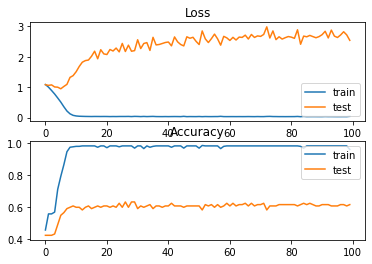

In [33]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

### Save the Best Model

In [34]:
import joblib
final_model = grid.best_estimator_
filename = '../webapp/static/Resources/gender_perfume_model.sav'
joblib.dump(final_model, filename)

# Save scaler
# filename = '../webapp/static/Resources/gender_perfume_model_scaler.sav'
# joblib.dump(X_scaler, filename)


['../webapp/static/Resources/gender_perfume_model.sav']